In [ ]:
#!pip install datasets

In [ ]:
import pandas as pd
import re
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/pacemaker50K.csv", dtype=str, low_memory=False)
df = df[df["FOI_TEXT"].notna()]
df = df[df["ADVERSE_EVENT_FLAG"].isin(['Y', 'N', 'True', 'False', True, False])]
df["ADVERSE_EVENT_FLAG"] = df["ADVERSE_EVENT_FLAG"].map({'Y': 1, 'N': 0, 'True': 1, 'False': 0, True: 1, False: 0})
df["FOI_TEXT"] = df["FOI_TEXT"].astype(str)
df = df[df["FOI_TEXT"].str.strip() != ""]

In [ ]:
train_df, test_df = train_test_split(
    df[["FOI_TEXT", "ADVERSE_EVENT_FLAG"]].rename(columns={"ADVERSE_EVENT_FLAG": "label"}),
    test_size=0.2,
    stratify=df["ADVERSE_EVENT_FLAG"],
    random_state=42
)

train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# def tokenize(example):
#     return tokenizer(example["FOI_TEXT"], truncation=True)

# tokenized_train = train_dataset.map(tokenize, batched=True)
# tokenized_test = test_dataset.map(tokenize, batched=True)
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize(example):
    return tokenizer(example["FOI_TEXT"], padding=True, truncation=True, max_length=512) # add padding and max_length

tokenized_train = train_dataset.map(tokenize, batched=True)
tokenized_test = test_dataset.map(tokenize, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # DataCollatorWithPadding will handle padding automatically

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.1", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# training arguments
training_args = TrainingArguments(
    output_dir="./biobert_results",
    # evaluation_strategy="epoch",
    eval_strategy = "epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
)

In [18]:
# trainer and training BioBert
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

<ipython-input-18-da0c40d25abd>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.252800,0.329180
2,0.158600,0.338266
3,0.355200,0.356444


TrainOutput(global_step=15000, training_loss=0.24995172365903853, metrics={'train_runtime': 12865.0857, 'train_samples_per_second': 9.328, 'train_steps_per_second': 1.166, 'total_flos': 3.157315808768016e+16, 'train_loss': 0.24995172365903853, 'epoch': 3.0})


BioBERT Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.90      6531
           1       0.90      0.70      0.79      3469

    accuracy                           0.87     10000
   macro avg       0.88      0.83      0.85     10000
weighted avg       0.87      0.87      0.86     10000



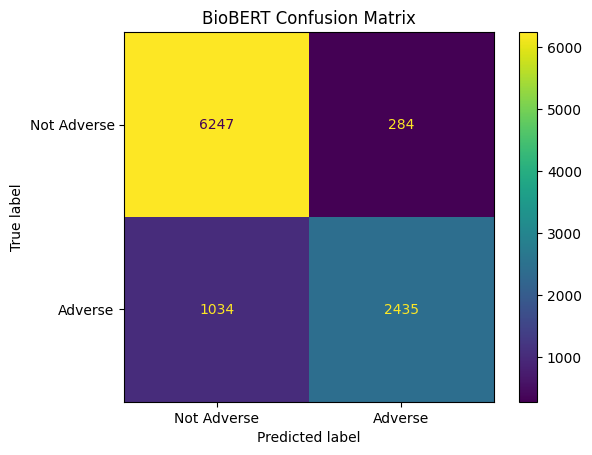

In [19]:
preds_output = trainer.predict(tokenized_test)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

print("\nBioBERT Classification Report:")
print(classification_report(y_true, y_pred))

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["Not Adverse", "Adverse"])
plt.title("BioBERT Confusion Matrix")
plt.show()


In [20]:
model.save_pretrained("biobert_finetuned_pacemaker")
tokenizer.save_pretrained("biobert_finetuned_pacemaker")

('biobert_finetuned_pacemaker/tokenizer_config.json',
 'biobert_finetuned_pacemaker/special_tokens_map.json',
 'biobert_finetuned_pacemaker/vocab.txt',
 'biobert_finetuned_pacemaker/added_tokens.json',
 'biobert_finetuned_pacemaker/tokenizer.json')